## Recursive feature elimination with Feature-engine

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,)

## Classification

In [24]:
data = pd.read_csv('dataset_1.csv')
data.shape

(50000, 301)

In [25]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


**Important**

Select the features by **examining only the training set** to **avoid overfit.**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((35000, 300), (15000, 300))

### Remove constant, quasi-constant and duplicated features

In [27]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),])
pipe.fit(X_train)
X_train = pipe.transform(X_train)# remove features
X_test = pipe.transform(X_test)
X_train.shape, X_test.shape

((35000, 152), (15000, 152))

### Recursive Feature Elimination

**The ML model for which we want to select features!**

In [28]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,)

**Setup the RFE selector!**

In [29]:
sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=2,) # cross-validation
sel.fit(X_train, y_train) # Quite a while --> A lot of models with cross-validation

RecursiveFeatureElimination(cv=2,
                            estimator=GradientBoostingClassifier(max_depth=2,
                                                                 n_estimators=10,
                                                                 random_state=10),
                            threshold=0.0005)

**Performance of model trained using all features!**

In [30]:
sel.initial_model_performance_

0.7989005422137565

**Importance of all features based of initial model!**

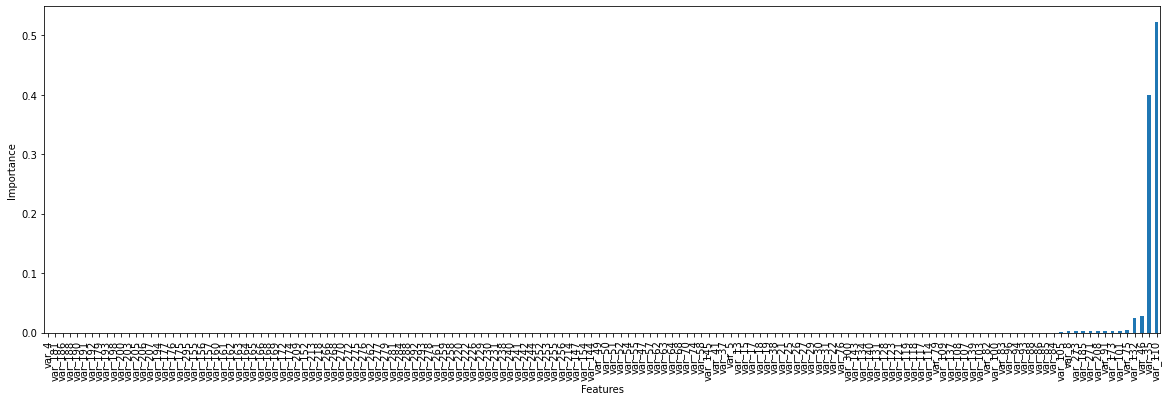

In [31]:
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

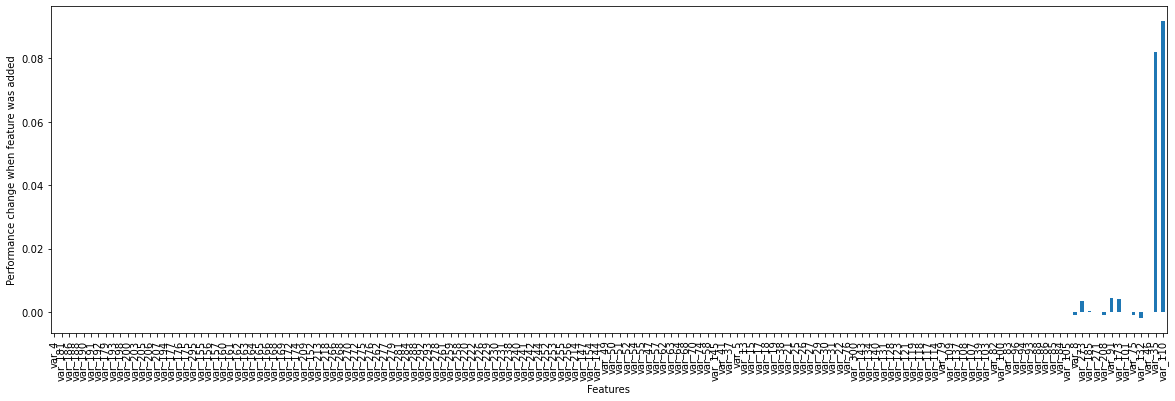

In [32]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

**Number of features that will be removed!**

In [33]:
len(sel.features_to_drop_)

147

**Select features!**

In [34]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_train.shape, X_test.shape

((35000, 5), (15000, 5))

**For comparison, fit the model with the selected features!**

In [35]:
model.fit(X_train, y_train)
y_pred_test = model.predict_proba(X_test)[:, 1]# make predictions
roc_final = roc_auc_score(y_test, y_pred_test)# calculate roc-auc
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.790604


As you can see, the **Gradient Boosting model** built with **5 features** shows a **similar performance** than the one built the full dataset (you need to scroll up to find this value, we calculated a few cells ago).

## Regression

In [36]:
data = pd.read_csv('HousingPrices_train.csv')
data.shape

(1460, 81)

**For simplicity I will use only numerical variables! Select numerical columns:**

In [37]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [39]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Recursive Feature Elimination

**Build initial model using all the features!**

In [40]:
model = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)
sel = RecursiveFeatureElimination(   # Setup the RFE selector
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'r2', # the metric we want to evalute
    threshold = 0.001, # the maximum performance drop allowed to remove a feature
    cv=3,) # cross-validation
sel.fit(X_train, y_train)  # Quite a while! A lot of models with cross-validation!

RecursiveFeatureElimination(estimator=GradientBoostingRegressor(max_depth=4,
                                                                n_estimators=10,
                                                                random_state=10),
                            scoring='r2', threshold=0.001)

**Performance of model trained using all features!**

In [41]:
sel.initial_model_performance_

0.7007152795529389

**Importance of all features based of initial model!**

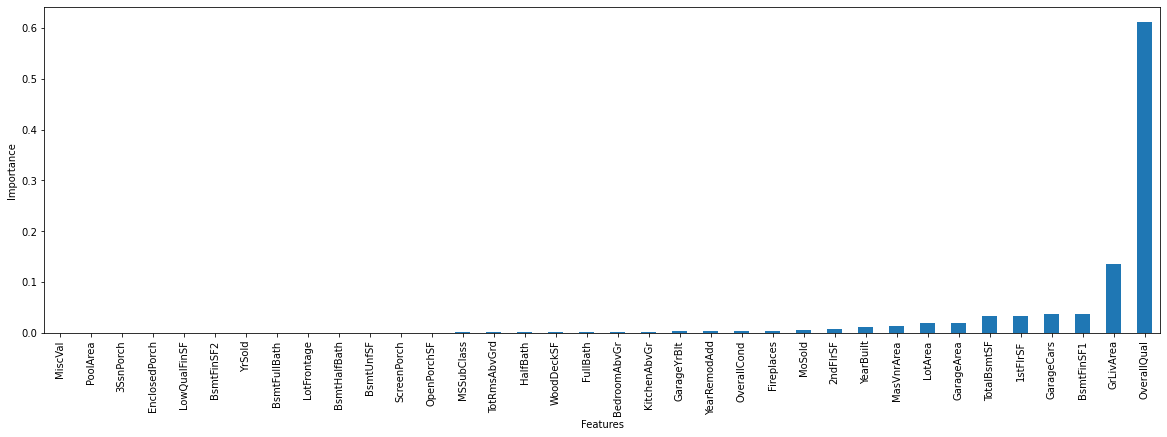

In [42]:
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

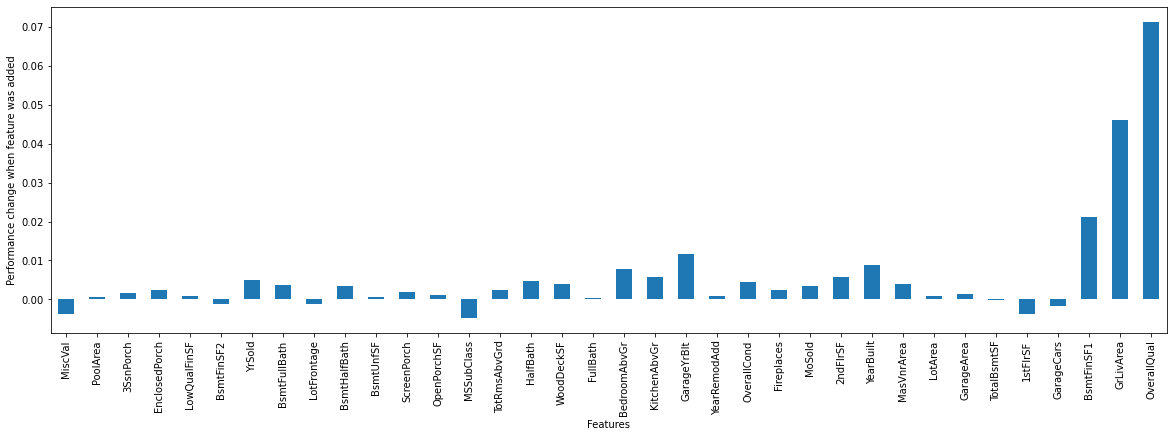

In [43]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

**Number of features that will be removed!**

In [44]:
len(sel.features_to_drop_)

13

In [45]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((1022, 23), (438, 23))

**Test the performance of the model built on the selected features!**

In [47]:
model.fit(X_train, y_train)  # fit the model with the selected features
y_pred_test = model.predict(X_test)  # make predictions
r2_final = r2_score(y_test, y_pred_test)  # calculate roc-auc
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.724467


The model built with **23 features** shows **similar or slightly better performance**! (you need to scroll up to find this value, we calculated a few cells ago).